In [1]:
!pip install geomstats

In [2]:
# Initialization
import os
import subprocess

import matplotlib.pyplot as plt
import numpy as np

import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.preprocessing import ToTangentSpace
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.pca import TangentPCA

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(1)
gs.random.seed(1000)

INFO: Using numpy backend


In [3]:
# data 
sphere = Hypersphere(dim=2)
cluster = sphere.random_von_mises_fisher(kappa=20, n_samples=100)

SO3 = SpecialOrthogonal(3)

# SO3.random_uniform()
rotation1 = np.array([
                      [-0.74956842, -0.64724411, -0.13864427],
                      [-0.10778045, -0.0873166,   0.99033287],
                      [-0.65309307,  0.75726539, -0.00431049]
]) 

rotation2 = np.array([
                      [-0.69009745,  0.04150329, -0.72252542],
                      [-0.71781048, -0.16653628,  0.67602795],
                      [-0.09226932,  0.98516148,  0.14471776]
])

cluster_1 =  cluster @ rotation1
cluster_2 =  cluster @ rotation2

data = gs.concatenate((cluster_1, cluster_2), axis=0)

true_labels = [0] * len(cluster_1) 
true_labels.extend([1] * len(cluster_2))
true_labels = np.array(true_labels)


In [4]:
from geomstats.geometry.hypersphere import Hypersphere

manifold = Hypersphere(dim=2)
metric = manifold.metric

In [5]:
def plot_sphere(_data, _labels, centroids=None):
    fig = plt.figure(figsize=(15, 15))
    colors = ['red', 'blue']

    ax = visualization.plot(
        _data,
        space='S2',
        marker='.',
        color='grey')

    for i in range(2):
        ax = visualization.plot(
            points=_data[_labels == i],
            ax=ax,
            space='S2',
            marker='.',
            color=colors[i],
            alpha=1)

    if centroids:
        for i, c in enumerate(centroids):
            ax = visualization.plot(
                c,
                ax=ax,
                space='S2',
                marker='*',
                s=2000,
                color=colors[i])

    ax.set_title('Kmeans on Hypersphere Manifold');
    ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])

In [6]:

def plot_tangent_space(_data, _labels, tangent_space, centroids=None):

    tangent_space.fit(_data)
    new_data = tangent_space.transform(_data)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    markers = ['o', '^']
    colors = ["blue", "red"]
    for i in range(2):
        points = new_data[_labels == i]
        xs = [x[0] for x in points]
        ys = [x[1] for x in points]
        zs = [x[2] for x in points]
        ax.scatter(xs, ys, zs, marker=markers[i], color=colors[i])


    plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


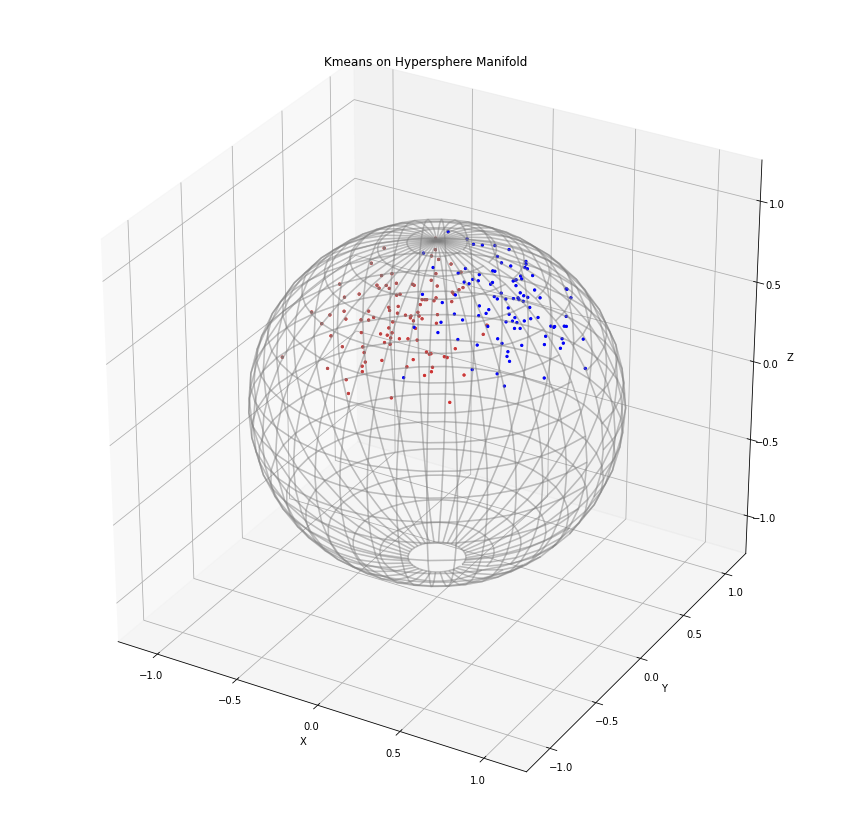

In [7]:
plot_sphere(data, true_labels)

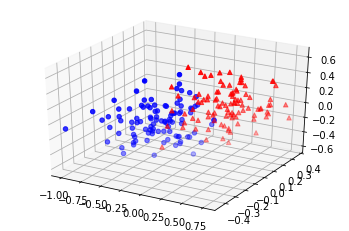

In [8]:
plot_tangent_space(data, true_labels, tangent_space=ToTangentSpace(geometry=metric))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data, true_labels, test_size=0.33, random_state=42)

In [10]:
def get_accuracy(_true, _pred):
    acc = accuracy_score(_true, _pred)
    if acc < 0.2:
        _pred = [(p + 1) % 2 for p in _pred]
    return accuracy_score(_true, _pred)

#Geomstats KMeans

In [11]:
from geomstats.learning.kmeans import RiemannianKMeans
from sklearn.model_selection import cross_validate

kmeans = RiemannianKMeans(metric, 2, tol=1e-3)
kmeans.fit(X_train)
predicted = kmeans.predict(X_test)
centroids = kmeans.centroids

accuracy = get_accuracy(y_test, predicted)
print(accuracy)

0.9242424242424242


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


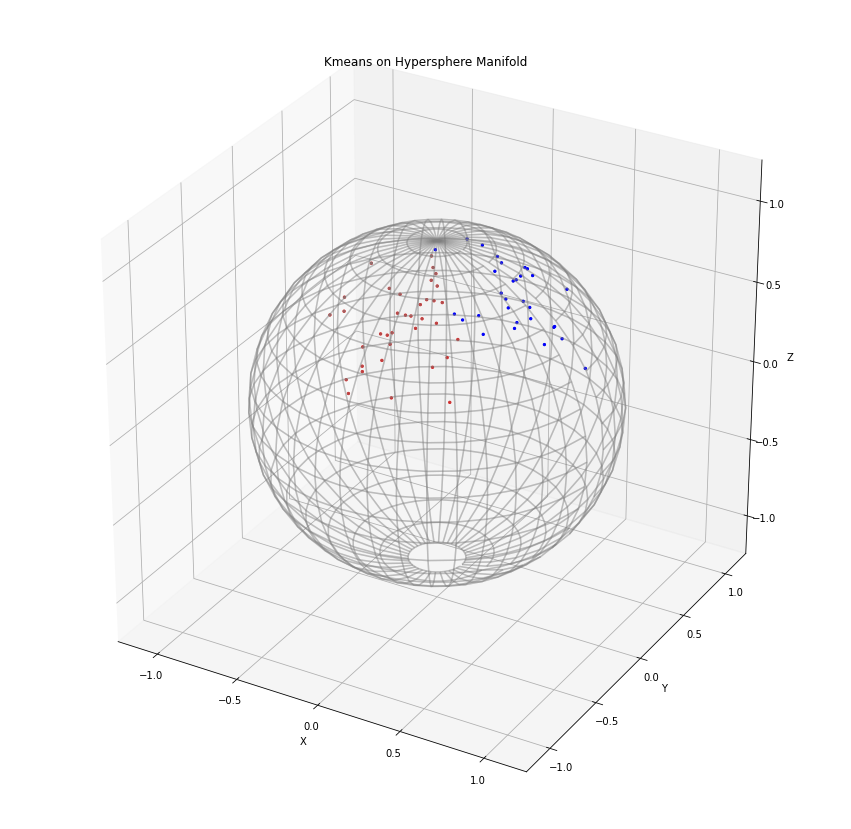

In [12]:
plot_sphere(X_test, predicted)

#Sklearn KMeans

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

pipeline = Pipeline(
    steps=[('feature_ext', ToTangentSpace(geometry=metric)),
           ('classifier', KMeans(n_clusters=2))])

pipeline.fit(X_train)
predicted = pipeline.predict(X_test)

accuracy = get_accuracy(y_test, predicted)
print(accuracy)

0.9242424242424242


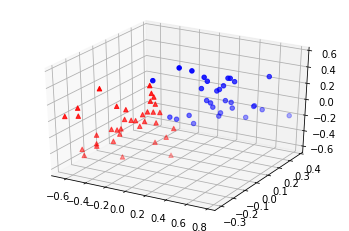

In [14]:
plot_tangent_space(X_test, predicted, ToTangentSpace(geometry=metric))

#Geomstats KMedoids

In [15]:
from geomstats.learning.kmedoids import RiemannianKMedoids

kmedoids = RiemannianKMedoids(metric, 2)
kmedoids.fit(X_train)
predicted = kmedoids.predict(X_test)

accuracy = get_accuracy(y_test, predicted)
print(accuracy)

0.9242424242424242


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


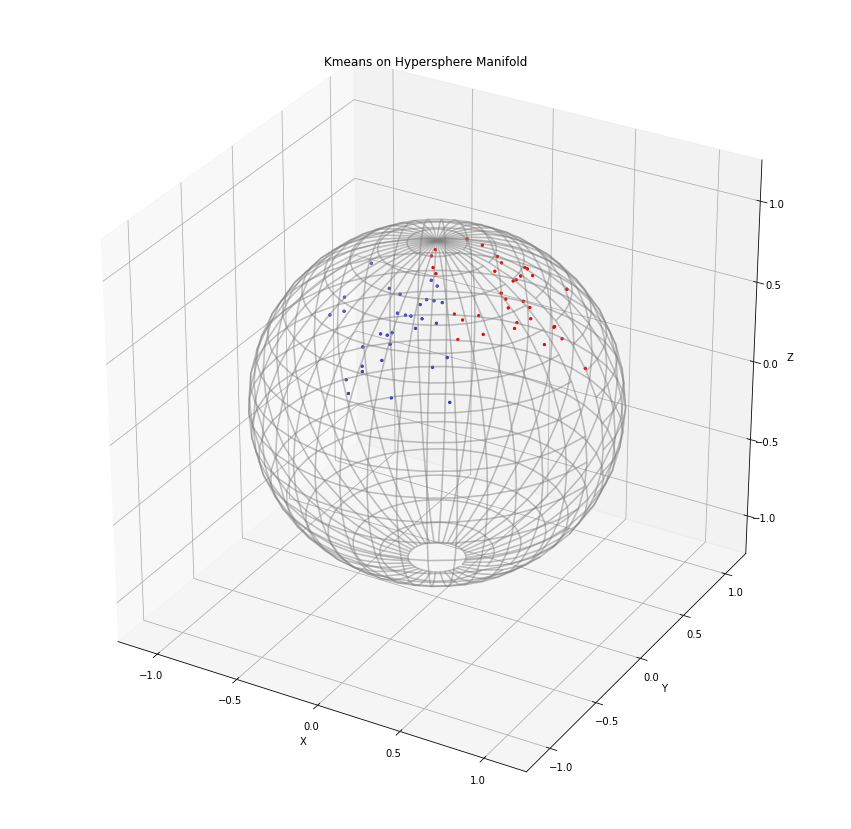

In [16]:
plot_sphere(X_test, predicted)

#Sklearn KMedoids

In [17]:
!pip install scikit-learn-extra

In [18]:
from sklearn_extra.cluster import KMedoids

pipeline = Pipeline(
    steps=[('feature_ext', ToTangentSpace(geometry=metric)),
           ('classifier', KMedoids(n_clusters=2))])

pipeline.fit(X_train)
predicted = pipeline.predict(X_test)

accuracy = get_accuracy(y_test, predicted)
print(accuracy)

0.9090909090909091


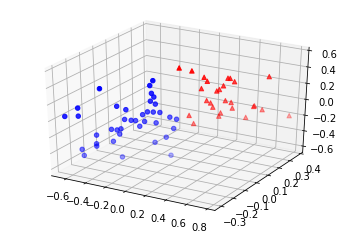

In [19]:
plot_tangent_space(X_test, predicted, ToTangentSpace(geometry=metric))

#Geomstats AgglomerativeHierarchicalClustering

##Euclidean distance

0.495


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


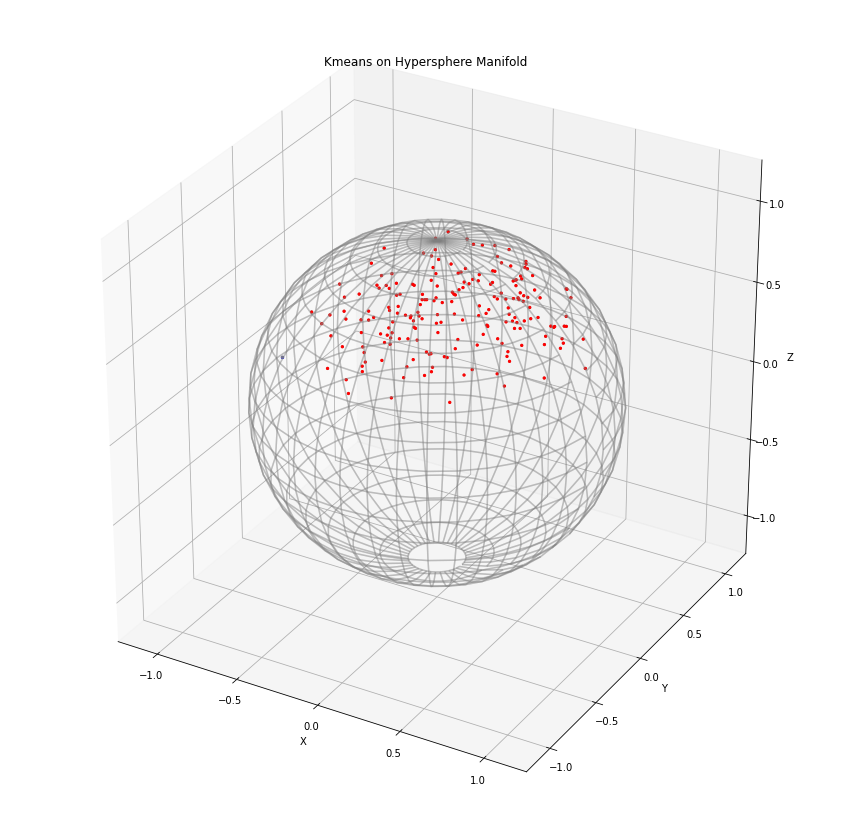

In [20]:

from geomstats.learning.agglomerative_hierarchical_clustering import AgglomerativeHierarchicalClustering

hierarchical_clustering = AgglomerativeHierarchicalClustering(n_clusters=2, distance='euclidean')

predicted = hierarchical_clustering.fit_predict(data)

accuracy = get_accuracy(true_labels, predicted)
print(accuracy)

plot_sphere(data, predicted)

##L2 distance

0.495


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


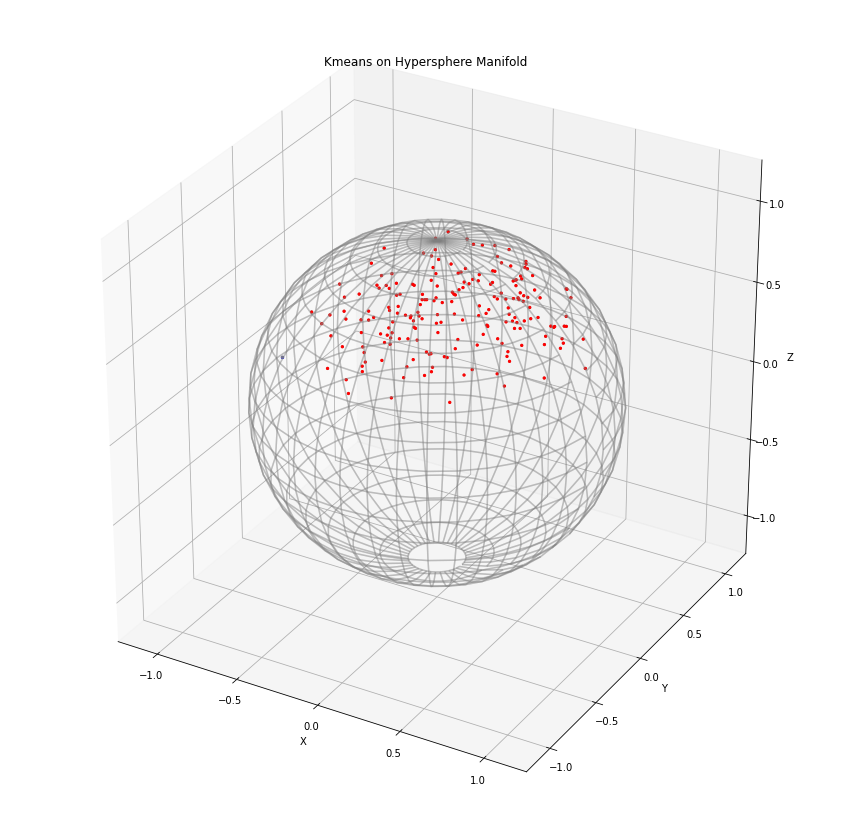

In [21]:
hierarchical_clustering = AgglomerativeHierarchicalClustering(n_clusters=2, distance='l2')

predicted = hierarchical_clustering.fit_predict(data)

accuracy = get_accuracy(true_labels, predicted)
print(accuracy)

plot_sphere(data, predicted)

##L1 distance

0.845


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


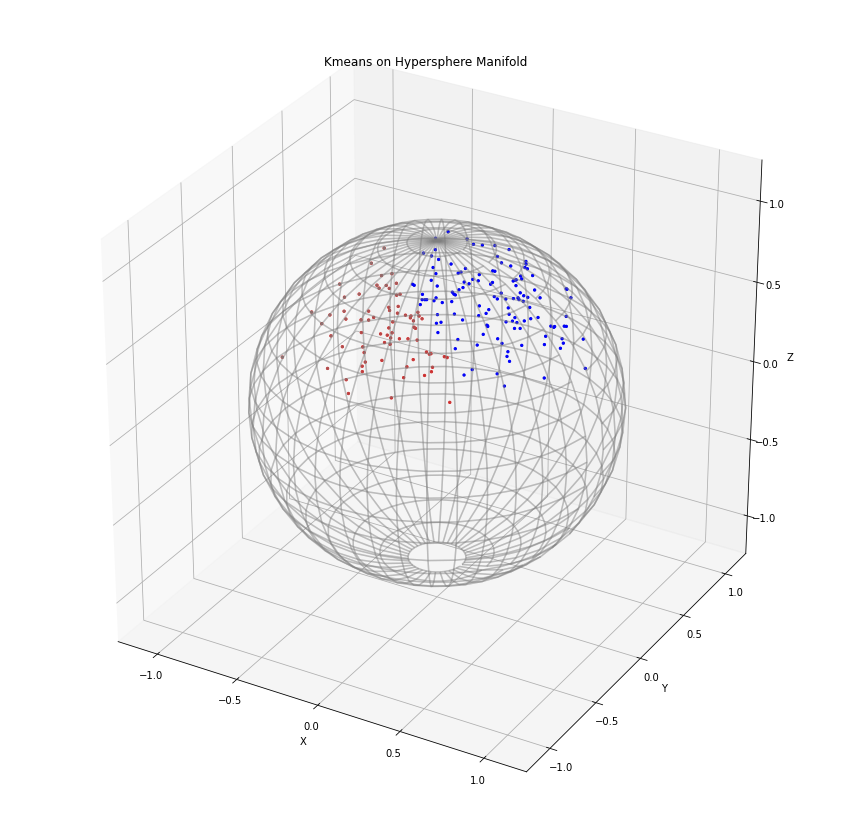

In [22]:
hierarchical_clustering = AgglomerativeHierarchicalClustering(n_clusters=2, distance='l1')

predicted = hierarchical_clustering.fit_predict(data)

accuracy = get_accuracy(true_labels, predicted)
print(accuracy)

plot_sphere(data, predicted)

##Cosine distance

0.89


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


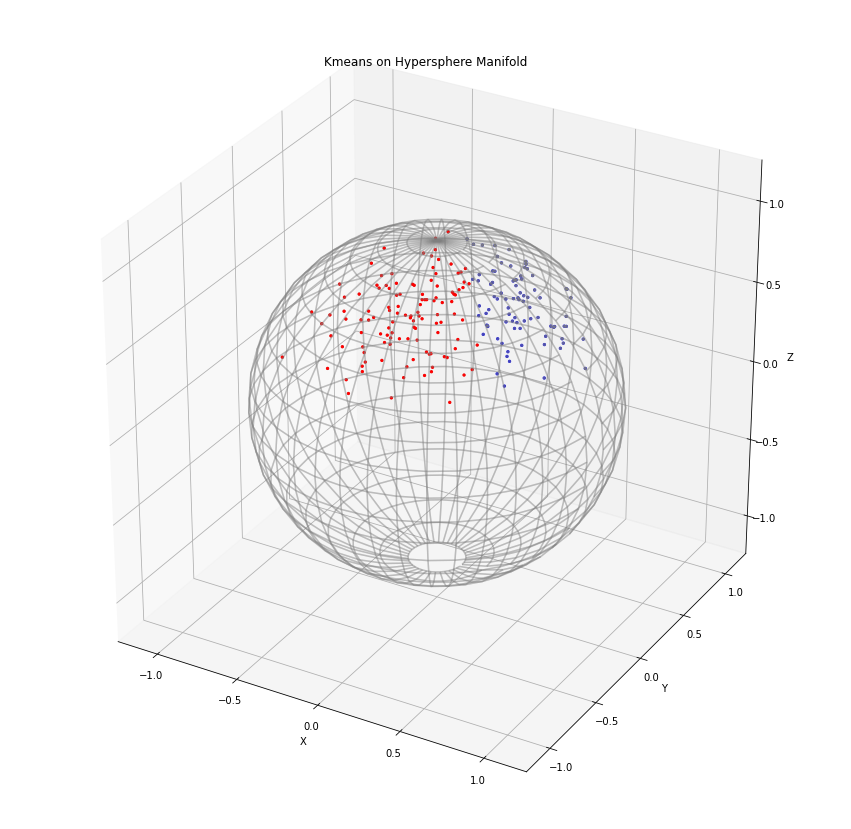

In [23]:
hierarchical_clustering = AgglomerativeHierarchicalClustering(n_clusters=2, distance='cosine')

predicted = hierarchical_clustering.fit_predict(data)

accuracy = get_accuracy(true_labels, predicted)
print(accuracy)

plot_sphere(data, predicted)

#Sklearn AgglomerativeClustering


##Euclidean distance

0.835


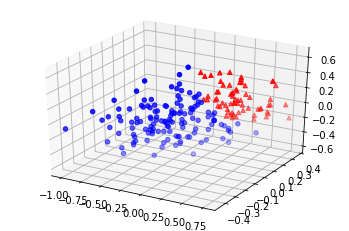

In [24]:
from sklearn.cluster import AgglomerativeClustering

tangent_space = ToTangentSpace(geometry=metric)

pipeline = Pipeline(
    steps=[('feature_ext', ToTangentSpace(geometry=metric)),
           ('classifier', AgglomerativeClustering(n_clusters=2, affinity='euclidean'))])

predicted = pipeline.fit_predict(data)

accuracy = get_accuracy(true_labels, predicted)
print(accuracy)

plot_tangent_space(data, predicted, ToTangentSpace(geometry=metric))


##L2 distance

0.495


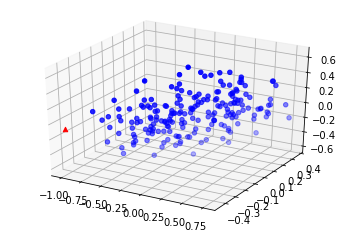

In [25]:
from sklearn.cluster import AgglomerativeClustering

tangent_space = ToTangentSpace(geometry=metric)

pipeline = Pipeline(
    steps=[('feature_ext', ToTangentSpace(geometry=metric)),
           ('classifier', AgglomerativeClustering(n_clusters=2, affinity='l2', linkage="average"))])

predicted = pipeline.fit_predict(data)

accuracy = get_accuracy(true_labels, predicted)
print(accuracy)

plot_tangent_space(data, predicted, ToTangentSpace(geometry=metric))


##L1 distance

0.88


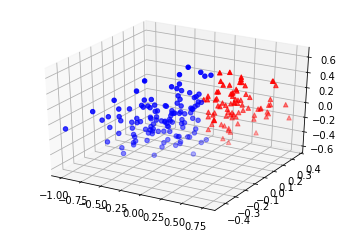

In [26]:
from sklearn.cluster import AgglomerativeClustering

tangent_space = ToTangentSpace(geometry=metric)

pipeline = Pipeline(
    steps=[('feature_ext', ToTangentSpace(geometry=metric)),
           ('classifier', AgglomerativeClustering(n_clusters=2, affinity='l1', linkage="average"))])

predicted = pipeline.fit_predict(data)

accuracy = get_accuracy(true_labels, predicted)
print(accuracy)

plot_tangent_space(data, predicted, ToTangentSpace(geometry=metric))


##Cosine distance

0.87


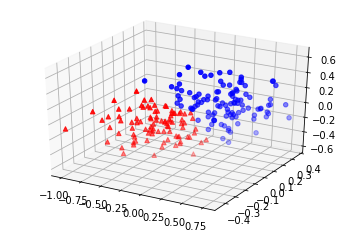

In [27]:
from sklearn.cluster import AgglomerativeClustering

tangent_space = ToTangentSpace(geometry=metric)

pipeline = Pipeline(
    steps=[('feature_ext', ToTangentSpace(geometry=metric)),
           ('classifier', AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage="average"))])

predicted = pipeline.fit_predict(data)

accuracy = get_accuracy(true_labels, predicted)
print(accuracy)

plot_tangent_space(data, predicted, ToTangentSpace(geometry=metric))
